<a name='top' />

### AutoEncoder
* <a href=#autoencoder>Simplest AutoEncoder</a>
* <a href=#bookmark>Adding singularity term for more compact result</a>
* <a href=#genimg>Generating Image</a>

### DeepAutoEncoder
* <a href=#deepautoencoder>DeepAutoEncoder</a>
* <a href=#convolution>Convolutional AutoEncoder</a>
* <a href=#denoising>Image Denoising</a>
* <a href=#vae>Variational autoencoder (VAE)</a>

<a name='autoencoder' />

#### Simplest AutoEncoder

In [50]:
from keras.layers import Input,Dense
from keras.models import Model

#autoEncoder結構:784->32->784
encoding_dim=32
input_img=Input(shape=(784,))
#only 2 layers:encoder and decoder
#這兩個是串在一起的,decoded本身就是autoencoder整體
encoded=Dense(encoding_dim,activation='relu')(input_img)
decoded=Dense(784,activation='sigmoid')(encoded)

#autoencoder=input_img+encoder+decoder
autoencoder=Model(input_img,decoded)
encoder=Model(input_img,encoded)

#單獨製造decoder,訓練玩以吼可以拿來產生(預測)數字
encoded_input=Input(shape=(encoding_dim,))
decoder_layer=autoencoder.layers[-1]
decoder=Model(encoded_input,decoder_layer(encoded_input))

#tutorial用adadelta, adam表現更好
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')

from keras.datasets import mnist
import numpy as np
(x_train,_),(x_test,_)=mnist.load_data()
x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.
x_train=x_train.reshape(len(x_train),np.prod(x_train.shape[1:]))
x_test=x_test.reshape(len(x_test),np.prod(x_test.shape[1:]))

print(x_train.shape)
print(x_test.shape)

autoencoder.fit(x_train,x_train,epochs=50,batch_size=256,shuffle=True,validation_data=(x_test,x_test))

(60000, 784)
(10000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 14s - loss: 0.2731 - val_loss: 0.1900
Epoch 2/50
60000/60000 [==============================] - 14s - loss: 0.1707 - val_loss: 0.1534
Epoch 3/50
60000/60000 [==============================] - 12s - loss: 0.1443 - val_loss: 0.1338
Epoch 4/50
60000/60000 [==============================] - 13s - loss: 0.1285 - val_loss: 0.1214
Epoch 5/50
60000/60000 [==============================] - 13s - loss: 0.1182 - val_loss: 0.1131
Epoch 6/50
60000/60000 [==============================] - 12s - loss: 0.1113 - val_loss: 0.1076
Epoch 7/50
60000/60000 [==============================] - 12s - loss: 0.1062 - val_loss: 0.1031
Epoch 8/50
60000/60000 [==============================] - 12s - loss: 0.1024 - val_loss: 0.0999
Epoch 9/50
60000/60000 [==============================] - 12s - loss: 0.0996 - val_loss: 0.0973
Epoch 10/50
60000/60000 [==============================] - 1

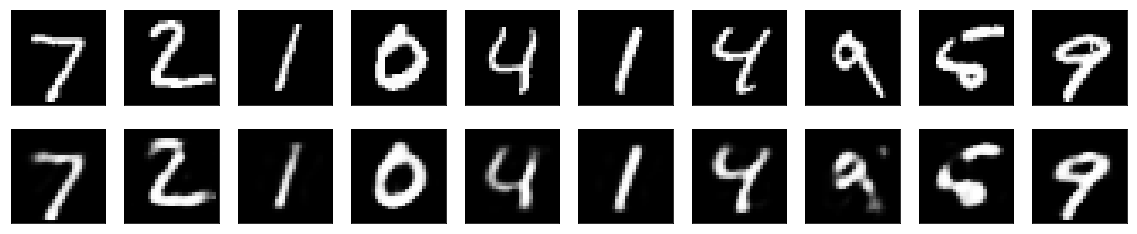

In [51]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [52]:
#像素值的平均值
encoded_imgs.mean()

8.7293129

save and load model

In [53]:
import json
from keras.applications import imagenet_utils
with open('./simple.json', 'w') as jsOut:
    json.dump(autoencoder.to_json(), jsOut)
    
autoencoder.save_weights('./simple_weight.h5')

In [54]:
from keras.models import model_from_json
with open('./simple.json', 'r') as jsIn:
    modelJson=json.load(jsIn)

modelLoaded=model_from_json(modelJson)
modelLoaded.load_weights('./simple_weight.h5')

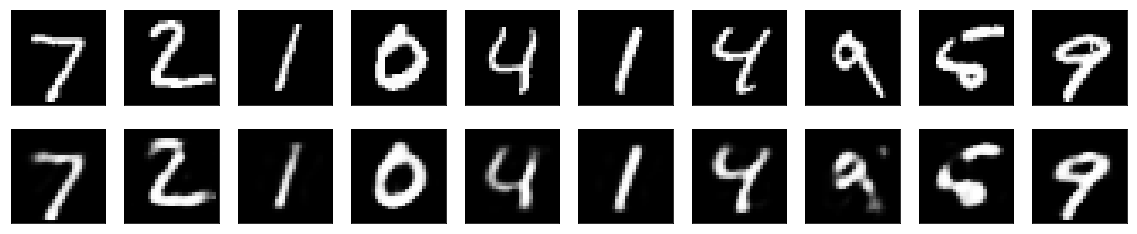

In [55]:
#check
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
img=modelLoaded.predict(x_test)

import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

<a name='bookmark' />
<a href=#top>Back To Top</a>

#### Adding singularity term for more compact result 

In [37]:
from keras import regularizers
encoding_dim=32
input_img=Input(shape=(784,))
#10e-5有問題
encoded=Dense(encoding_dim,activation='relu',activity_regularizer=regularizers.l1(0.00001))(input_img)
decoded=Dense(784,activation='sigmoid')(encoded)

autoencoder=Model(input_img,decoded)
encoder=Model(input_img,encoded)

#單獨製造decoder,訓練玩以吼可以拿來產生(預測)數字
encoded_input=Input(shape=(encoding_dim,))
decoder_layer=autoencoder.layers[-1]
decoder=Model(encoded_input,decoder_layer(encoded_input))

from keras.datasets import mnist
import numpy as np
(x_train,_),(x_test,_)=mnist.load_data()
x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.
x_train=x_train.reshape(len(x_train),np.prod(x_train.shape[1:]))
x_test=x_test.reshape(len(x_test),np.prod(x_test.shape[1:]))

autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
#加regularization term 可以訓練比較久，因為不比較不會overfitting
autoencoder.fit(x_train,x_train,epochs=100,batch_size=256,shuffle=True,validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 9s - loss: 0.4086 - val_loss: 0.2802
Epoch 2/100
60000/60000 [==============================] - 8s - loss: 0.2509 - val_loss: 0.2335
Epoch 3/100
60000/60000 [==============================] - 8s - loss: 0.2271 - val_loss: 0.2190
Epoch 4/100
60000/60000 [==============================] - 6s - loss: 0.2146 - val_loss: 0.2085
Epoch 5/100
60000/60000 [==============================] - 7s - loss: 0.2052 - val_loss: 0.1997
Epoch 6/100
60000/60000 [==============================] - 6s - loss: 0.1972 - val_loss: 0.1931
Epoch 7/100
60000/60000 [==============================] - 7s - loss: 0.1916 - val_loss: 0.1883
Epoch 8/100
60000/60000 [==============================] - 9s - loss: 0.1873 - val_loss: 0.1844
Epoch 9/100
60000/60000 [==============================] - 10s - loss: 0.1839 - val_loss: 0.1813
Epoch 10/100
60000/60000 [==============================] - 9s - loss: 0.1812 - val_l

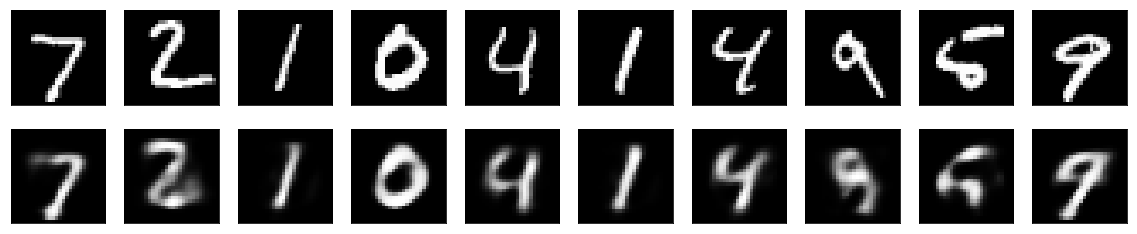

In [38]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [39]:
encoded_imgs.mean()
#compare to 9.0137386 the result is sparsity, implying that autoencoder is more comapct
#犧牲Loss換取穩定性
#ref:https://www.zhihu.com/question/26602796

0.11979768

<a name='genimg' />
<a href=#top>Back To Top</a>

### Generating Image

loading model

In [6]:
from keras.models import model_from_json
import json
with open('./deepauto.json', 'r') as jsIn:
    modelJson=json.load(jsIn)

modelLoaded=model_from_json(modelJson)
modelLoaded.load_weights('./deepauto.h5')

In [7]:
from keras.layers import Input,Dense
from keras.models import Model

#encoder取encoded3(從1~3都包)
input_img=Input(shape=(784,))
encoder_layer1=modelLoaded.layers[0](input_img)
encoder_layer2=modelLoaded.layers[1](encoder_layer1)
encoder_layer3=modelLoaded.layers[2](encoder_layer2)
encoder=Model(input_img,encoder_layer3)

#單獨製造decoder,訓練玩以吼可以拿來產生(預測)數字
#分三次把decoded layer1~3抓出來，再疊成tensor
encoded_input=Input(shape=(2,))
decoder_layer1=modelLoaded.layers[-3]
decoder_layer2=modelLoaded.layers[-2]
decoder_layer3=modelLoaded.layers[-1]

decoder_layer=decoder_layer2(decoder_layer1(encoded_input))
decoder_layer=decoder_layer3(decoder_layer)

decoder=Model(encoded_input,decoder_layer)

從頭跑一遍

In [3]:
from keras.layers import Input,Dense
from keras.models import Model
input_img=Input(shape=(784,))

encoded1=Dense(128,activation='relu')(input_img)
encoded2=Dense(64,activation='relu')(encoded1)
encoded3=Dense(2,activation='relu')(encoded2)
decoded1=Dense(64,activation='relu')(encoded3)
decoded2=Dense(128,activation='relu')(decoded1)
decoded3=Dense(784,activation='sigmoid')(decoded2)

autoencoder=Model(input_img,decoded3)

from keras.datasets import mnist
import numpy as np
(x_train,_),(x_test,_)=mnist.load_data()
x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.
x_train=x_train.reshape(len(x_train),np.prod(x_train.shape[1:]))
x_test=x_test.reshape(len(x_test),np.prod(x_test.shape[1:]))

autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=10,batch_size=256,shuffle=True,validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 12s - loss: 0.2977 - val_loss: 0.2546
Epoch 2/10
60000/60000 [==============================] - 11s - loss: 0.2430 - val_loss: 0.2243
Epoch 3/10
60000/60000 [==============================] - 9s - loss: 0.2164 - val_loss: 0.2096
Epoch 4/10
60000/60000 [==============================] - 10s - loss: 0.2068 - val_loss: 0.2036s: 0.
Epoch 5/10
60000/60000 [==============================] - 10s - loss: 0.2022 - val_loss: 0.2004
Epoch 6/10
60000/60000 [==============================] - 12s - loss: 0.1991 - val_loss: 0.1977
Epoch 7/10
60000/60000 [==============================] - 10s - loss: 0.1965 - val_loss: 0.1953
Epoch 8/10
60000/60000 [==============================] - 13s - loss: 0.1941 - val_loss: 0.1935
Epoch 9/10
60000/60000 [==============================] - 10s - loss: 0.1923 - val_loss: 0.1920
Epoch 10/10
60000/60000 [==============================] - 10s - loss: 0.1908 - va

In [4]:
#encoder取encoded3(從1~3都包)
encoder=Model(input_img,encoded3)

#單獨製造decoder,訓練玩以吼可以拿來產生(預測)數字
#分三次把decoded layer1~3抓出來，再疊成tensor
encoded_input=Input(shape=(2,))
decoder_layer1=autoencoder.layers[-3]
decoder_layer2=autoencoder.layers[-2]
decoder_layer3=autoencoder.layers[-1]

decoder_layer=decoder_layer2(decoder_layer1(encoded_input))
decoder_layer=decoder_layer3(decoder_layer)

decoder=Model(encoded_input,decoder_layer)

畫圖

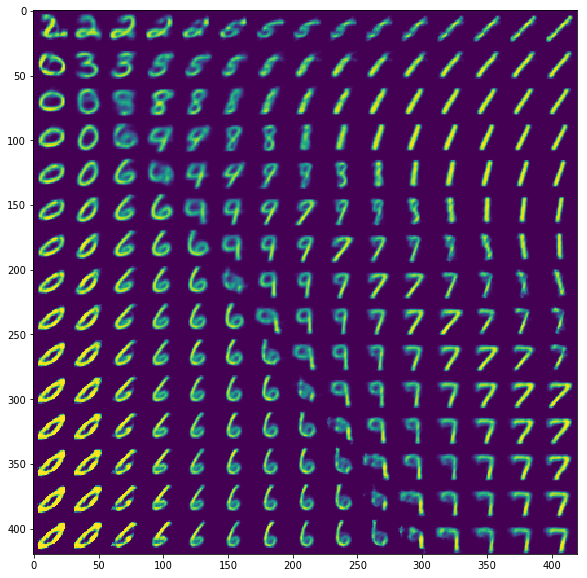

In [8]:
import numpy as np
import matplotlib.pyplot as plt
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(0, 50, n)
grid_y = np.linspace(0, 50, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) 
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

<a name='deepautoencoder' />
<a href=#top>Back To Top</a>

#### DeepAutoEncoder

In [40]:
input_img=Input(shape=(784,))

encoded1=Dense(128,activation='relu')(input_img)
encoded2=Dense(64,activation='relu')(encoded1)
encoded3=Dense(32,activation='relu')(encoded2)
decoded1=Dense(64,activation='relu')(encoded3)
decoded2=Dense(128,activation='relu')(decoded1)
decoded3=Dense(784,activation='sigmoid')(decoded2)

autoencoder=Model(input_img,decoded3)

autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=100,batch_size=256,shuffle=True,validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 14s - loss: 0.2439 - val_loss: 0.1705
Epoch 2/100
60000/60000 [==============================] - 13s - loss: 0.1513 - val_loss: 0.1368
Epoch 3/100
60000/60000 [==============================] - 13s - loss: 0.1317 - val_loss: 0.1249
Epoch 4/100
60000/60000 [==============================] - 12s - loss: 0.1229 - val_loss: 0.1182
Epoch 5/100
60000/60000 [==============================] - 11s - loss: 0.1166 - val_loss: 0.1117
Epoch 6/100
60000/60000 [==============================] - 11s - loss: 0.1113 - val_loss: 0.1078
Epoch 7/100
60000/60000 [==============================] - 11s - loss: 0.1083 - val_loss: 0.1054
Epoch 8/100
60000/60000 [==============================] - 11s - loss: 0.1061 - val_loss: 0.1045
Epoch 9/100
60000/60000 [==============================] - 11s - loss: 0.1047 - val_loss: 0.1030
Epoch 10/100
60000/60000 [==============================] - 12s - loss: 0.103

60000/60000 [==============================] - 10s - loss: 0.0819 - val_loss: 0.0816
Epoch 85/100
60000/60000 [==============================] - 10s - loss: 0.0819 - val_loss: 0.0814
Epoch 86/100
60000/60000 [==============================] - 10s - loss: 0.0818 - val_loss: 0.0812
Epoch 87/100
60000/60000 [==============================] - 10s - loss: 0.0817 - val_loss: 0.0816
Epoch 88/100
60000/60000 [==============================] - 10s - loss: 0.0817 - val_loss: 0.0815
Epoch 89/100
60000/60000 [==============================] - 10s - loss: 0.0816 - val_loss: 0.0813
Epoch 90/100
60000/60000 [==============================] - 10s - loss: 0.0816 - val_loss: 0.0815
Epoch 91/100
60000/60000 [==============================] - 10s - loss: 0.0816 - val_loss: 0.0814
Epoch 92/100
60000/60000 [==============================] - 10s - loss: 0.0815 - val_loss: 0.0812
Epoch 93/100
60000/60000 [==============================] - 10s - loss: 0.0815 - val_loss: 0.0812
Epoch 94/100
60000/60000 [=======

In [75]:
#encoder取encoded3(從1~3都包)
encoder=Model(input_img,encoded3)

#單獨製造decoder,訓練玩以吼可以拿來產生(預測)數字
#分三次把decoded layer1~3抓出來，再疊成tensor
encoded_input=Input(shape=(32,))
decoder_layer1=autoencoder.layers[-3]
decoder_layer2=autoencoder.layers[-2]
decoder_layer3=autoencoder.layers[-1]

decoder_layer=decoder_layer2(decoder_layer1(encoded_input))
decoder_layer=decoder_layer3(decoder_layer)

decoder=Model(encoded_input,decoder_layer)

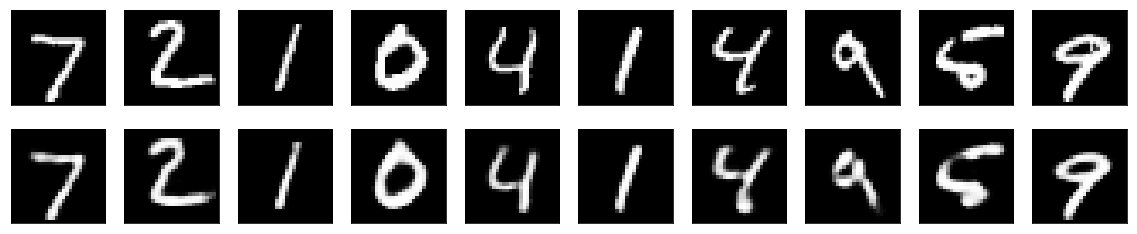

In [76]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#performance比較好

In [71]:
encoded_imgs.mean()

8.5405684

<a name='convolution'/>
<a href=#top>Back To Top</a>

### Convolutional autoencoder

In [92]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img=Input(shape=(28,28,1))

x=Conv2D(16,(3,3),activation='relu',padding='same')(input_img)
print(x.shape)
x=MaxPooling2D((2,2),padding='same')(x)
print(x.shape)
x=Conv2D(8,(3,3),activation='relu',padding='same')(x)
print(x.shape)
x=MaxPooling2D((2,2),padding='same')(x)
print(x.shape)
x=Conv2D(8,(3,3),activation='relu',padding='same')(x)
print(x.shape)
encoded=MaxPooling2D((2,2),padding='same')(x)
print(encoded.shape)

x=Conv2D(8,(3,3),activation='relu',padding='same')(encoded)
print(x.shape)
x=UpSampling2D((2,2))(x)
print(x.shape)
x=Conv2D(8,(3,3),activation='relu',padding='same')(x)
print(x.shape)
x=UpSampling2D((2,2))(x)
print(x.shape)
x=Conv2D(16,(3,3),activation='relu')(x)
print(x.shape)
x=UpSampling2D((2,2))(x)
print(x.shape)
decoded=Conv2D(1,(3,3),activation='sigmoid',padding='same')(x)
print(decoded.shape)

autoencoder=Model(input_img,decoded)
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')

from keras.datasets import mnist
import numpy as np
(x_train,_),(x_test,_)=mnist.load_data()
x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.
x_train=x_train.reshape(len(x_train),28,28,1)
x_test=x_test.reshape(len(x_test),28,28,1)

from keras.callbacks import TensorBoard
autoencoder.fit(x_train,x_train,epochs=50,batch_size=128,shuffle=True,validation_data=(x_test,x_test)
                ,callbacks=[TensorBoard(log_dir='.')])
#localhost:6006

(?, 28, 28, 16)
(?, 14, 14, 16)
(?, 14, 14, 8)
(?, 7, 7, 8)
(?, 7, 7, 8)
(?, 4, 4, 8)
(?, 4, 4, 8)
(?, 8, 8, 8)
(?, 8, 8, 8)
(?, 16, 16, 8)
(?, 14, 14, 16)
(?, 28, 28, 16)
(?, 28, 28, 1)
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 190s - loss: 0.2168 - val_loss: 0.1463
Epoch 2/50
60000/60000 [==============================] - 186s - loss: 0.1361 - val_loss: 0.1262
Epoch 3/50
60000/60000 [==============================] - 158s - loss: 0.1228 - val_loss: 0.1184
Epoch 4/50
60000/60000 [==============================] - 149s - loss: 0.1165 - val_loss: 0.1129
Epoch 5/50
60000/60000 [==============================] - 169s - loss: 0.1128 - val_loss: 0.1107
Epoch 6/50
60000/60000 [==============================] - 169s - loss: 0.1103 - val_loss: 0.1087
Epoch 7/50
60000/60000 [==============================] - 173s - loss: 0.1082 - val_loss: 0.1061
Epoch 8/50
60000/60000 [==============================] - 172s - loss: 0.1065 - val_

In [94]:
encoder=Model(input_img,encoded)

encoded_input=Input(shape=(4, 4, 8))
decoder_layer=encoded_input
for i in range(7):
    temp=autoencoder.layers[i-7]
    decoder_layer=temp(decoder_layer)

decoder=Model(encoded_input,decoder_layer)

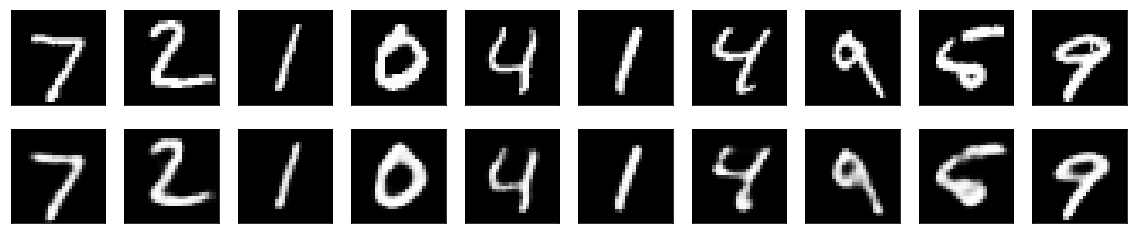

In [95]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [96]:
encoded_imgs.mean()

3.7210352

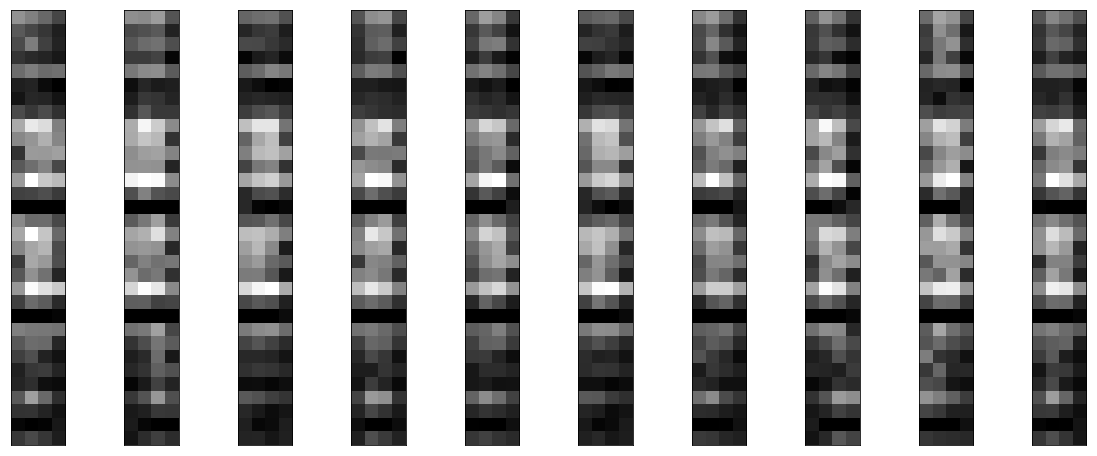

In [99]:
plt.figure(figsize=(20, 8))
for i in range(10):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(4, 32).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

<a name="denoising"/>
<a href=#top>Back To Top</a>

#### Image denoising

In [112]:
from keras.datasets import mnist
import numpy as np
(x_train,_),(x_test,_)=mnist.load_data()
x_train=x_train.astype('float32')/255.
x_test=x_test.astype('float32')/255.
x_train=x_train.reshape(len(x_train),28,28,1)
x_test=x_test.reshape(len(x_test),28,28,1)

noise_factor=0.5
x_train_noisy=x_train+noise_factor*np.random.normal(loc=0,scale=1,size=x_train.shape)
x_test_noisy=x_test+noise_factor*np.random.normal(loc=0,scale=1,size=x_test.shape)

x_train_noisy=np.clip(x_train_noisy,0,1)
x_test_noisy=np.clip(x_test_noisy,0,1)



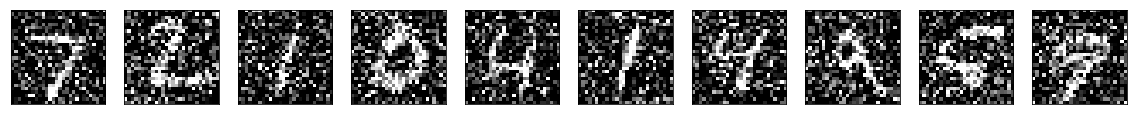

In [113]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

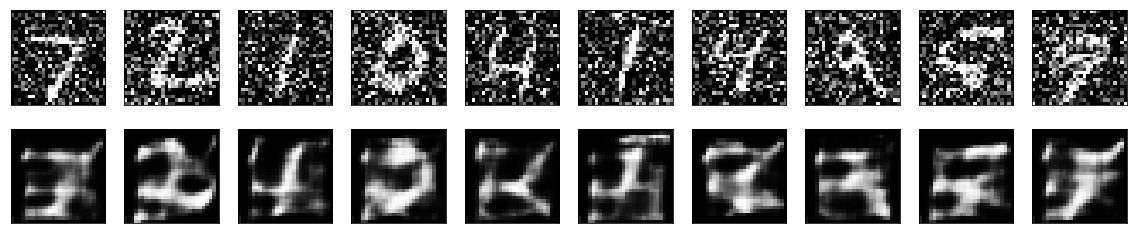

In [114]:
#用上一個範例的model輸入noisy data，結果很不好，無法很好的還原

encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)

import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [119]:
#用有雜訊的data訓練，但是target沒有雜訊，因此預期之後儘管輸入有雜訊的data，model也能正確還原
#負重訓練，但前提是目標要是正確的
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_img=Input(shape=(28,28,1))
x=Conv2D(32,(3,3),activation='relu',padding='same')(input_img)
x=MaxPooling2D((2,2))(x)
x=Conv2D(32,(3,3),activation='relu',padding='same')(x)
encoded=MaxPooling2D((2,2),padding='same')(x)
#print(encoded.shape)
#(?, 7, 7, 32)

x=Conv2D(32,(3,3),activation='relu',padding='same')(encoded)
x=UpSampling2D((2,2))(x)
x=Conv2D(32,(3,3),activation='relu',padding='same')(x)
x=UpSampling2D((2,2))(x)
decoded=Conv2D(1,(3,3),activation='sigmoid',padding='same')(x)

autoencoder=Model(input_img,decoded)
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')

autoencoder.fit(x_train_noisy,x_train,epochs=50,batch_size=128,shuffle=True,validation_data=(x_test_noisy,x_test)
                ,callbacks=[TensorBoard(log_dir='.', histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 411s - loss: 0.1676 - val_loss: 0.1179
Epoch 2/50
60000/60000 [==============================] - 325s - loss: 0.1141 - val_loss: 0.1098
Epoch 3/50
60000/60000 [==============================] - 297s - loss: 0.1088 - val_loss: 0.1061
Epoch 4/50
60000/60000 [==============================] - 354s - loss: 0.1059 - val_loss: 0.1037
Epoch 5/50
60000/60000 [==============================] - 359s - loss: 0.1038 - val_loss: 0.1020
Epoch 6/50
60000/60000 [==============================] - 361s - loss: 0.1022 - val_loss: 0.1005
Epoch 7/50
60000/60000 [==============================] - 342s - loss: 0.1009 - val_loss: 0.0995
Epoch 8/50
60000/60000 [==============================] - 363s - loss: 0.0999 - val_loss: 0.0986
Epoch 9/50
60000/60000 [==============================] - 352s - loss: 0.0991 - val_loss: 0.0980
Epoch 10/50
60000/60000 [==============================] - 347s - loss: 0.098

In [126]:
encoder=Model(input_img,encoded)

encoded_input=Input(shape=(7, 7, 32))
decoder_layer=encoded_input
for i in range(5):
    temp=autoencoder.layers[i-5]
    decoder_layer=temp(decoder_layer)

decoder=Model(encoded_input,decoder_layer)

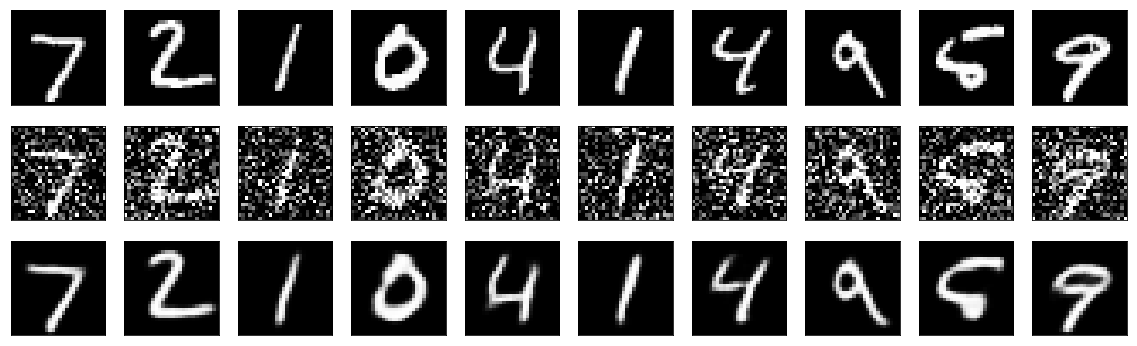

In [128]:
encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)

import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy
    ax = plt.subplot(3, n, i + 1+n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [123]:
encoded_imgs.mean()

5.1861744

<a href=#top>Back To Top</a>
<a name='vae'/>

### Variational autoencoder (VAE)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

#做2個NN(z_mean和z_log_var)
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    #epsilon是常態分布下亂數取出的noise
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
#把2個NN的output接在一起並做運算
#到z為止是原本的code加上noise的code，之後再接decoder
#z_mean是原始的code
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

Using TensorFlow backend.


In [10]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


# Custom loss layer
# class括號內為欲繼承的類別，這裡CustomVariationalLayer繼承了Layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        # 呼叫Layer的建構子__init__
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)


# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
#loss多了KL loss所以變大

c:\users\chiang\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Output "custom_variational_layer_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_2" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 14s - loss: 191.8588 - val_loss: 173.3773
Epoch 2/50
60000/60000 [==============================] - 16s - loss: 171.2200 - val_loss: 168.0784
Epoch 3/50
60000/60000 [==============================] - 17s - loss: 166.4065 - val_loss: 164.8744
Epoch 4/50
60000/60000 [==============================] - 17s - loss: 163.4877 - val_loss: 161.7580
Epoch 5/50
60000/60000 [==============================] - 16s - loss: 161.5055 - val_loss: 160.2696
Epoch 6/50
60000/60000 [==============================] - 13s - loss: 160.1739 - val_loss: 159.2342
Epoch 7/50
60000/60000 [==============================] - 13s - loss: 159.2214 - val_loss: 158.6562
Epoch 8/50
60000/60000 [==============================] - 13s - loss: 158.3787 - val_loss: 157.6615
Epoch 9/50
60000/60000 [==============================] - 13s - loss: 157.7488 - val_loss: 158.8104
Epoch 10/50
60000/60000 [=========================

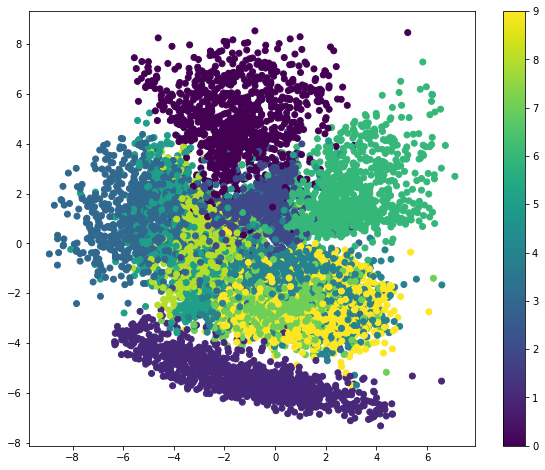

In [13]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(10, 8))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

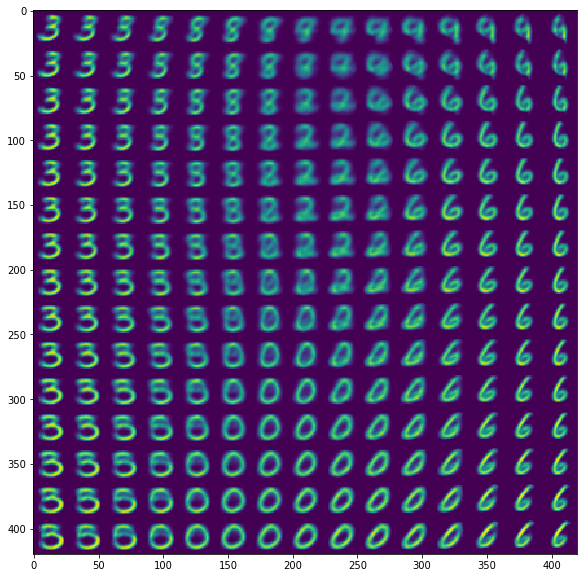

In [34]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(0, 6, n)
grid_y = np.linspace(-6, 6, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

<a href=#top>Back To Top</a>
<a name=''/>